In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [7]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [8]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-2.0, 2.0); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [41]:
Δtgif = 0.1

# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset, U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv
Nx = 3*config.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.0, 2.0, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

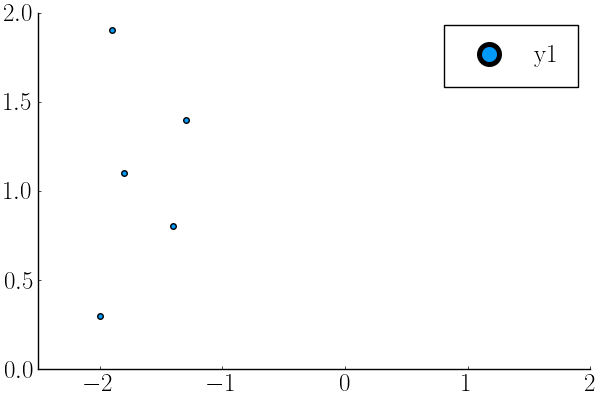

In [42]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [61]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = (blobs₊, blobs₋)

# data = generate_data_twin_experiment(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/LowRankVortex.jl/localization/data/");
tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/example2/data/data_vortex.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], 0.001, [-2.018587306805637, 0.3469573514039377, 0.45880001794294045, -1.8218225076346501, 1.8957320291019035, 0.3768744289098014, -1.8102180547912552, 1.0615219698346763, 0.26918155979815017, -1.273480600181778, 1.3996292681183138, 0.39099049767578464, -1.3586001809001103, 0.7834839950529129, 0.2327616928563841], [-2.018587306805637 -2.0172169502893196 … 12.59044061465947 12.591482987090947; 0.3469573514039377 0.3469042736866317 … 1.1421505993204804 1.1421716017979275; … ; 0.7834839950529129 0.7835958875071971 … 1.5055566951364918 1.5054079889283538; 0.2327616928563841 0.2327616928563841 … 0.2327616928563841 0.2327616928563841], [-0.524522656873511 -0.5090575008179341 … -0.4727590518054783 -0.4724508529842126; -0.5379397508961893 -0.5208171476572888 … -0.5119750022574816 -0.51414802719

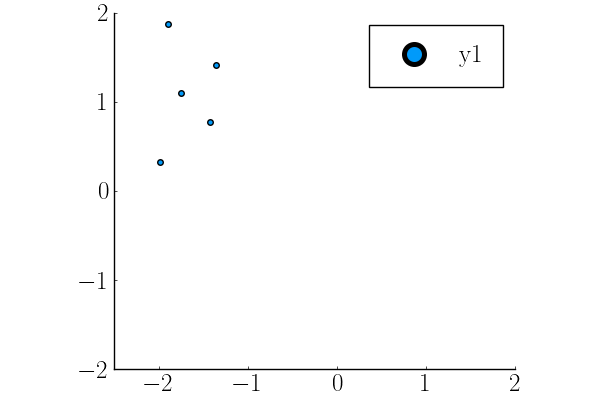

In [62]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

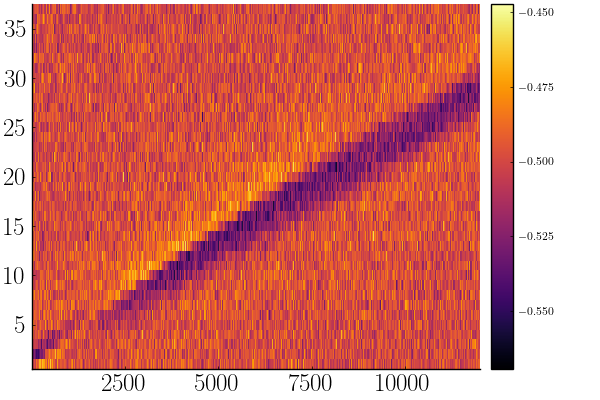

In [63]:
heatmap(data.yt)

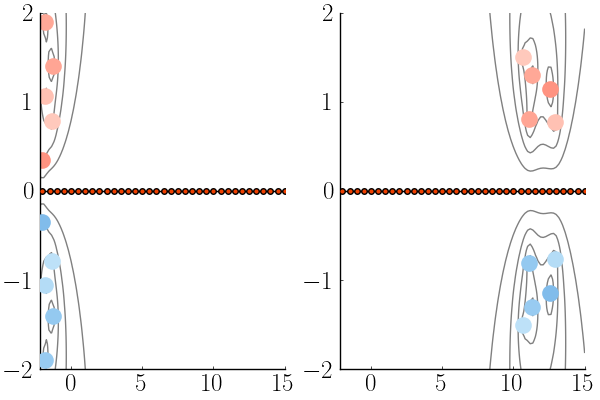

In [64]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

In [65]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config_data.Δt)+1
#     plt1 = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid; withvortices = true)
#     plt2 = plot(real(config_data.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config_data), xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), color = :teal, legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot(plt1, plt2)
# #     next!(prog)
# end

### Setup the sequential filter

In [69]:
config = deepcopy(config_data)

VortexConfig(5, 1.0 + 0.0im, ComplexF64[-2.0 + 0.0im, -1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im  …  11.5 + 0.0im, 12.0 + 0.0im, 12.5 + 0.0im, 13.0 + 0.0im, 13.5 + 0.0im, 14.0 + 0.0im, 14.5 + 0.0im, 15.0 + 0.0im, 15.5 + 0.0im, 16.0 + 0.0im], 0.001, 0.1, 0.0001, 0.0001, 1.0, 0.01)

In [77]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [78]:
senkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

Stochastic EnKF  with filtered = true


In [79]:
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

LREnKF  with filtered = true


In [80]:
Lxy = 1.0
Lyy = 1.0

1.0

In [81]:
Nelist = reverse([10; 12; 15; 20; 25; 30; 40; 50; 60; 80; 100])
# Nelist = [8; 5]
ratiolist = [0.85; 0.95; 0.99; 0.999]
Nrun = 50

for Ne in Nelist
    
    rmse_lowranktab_85 = zeros(Nrun)
    rmse_lowranktab_95 = zeros(Nrun)
    rmse_lowranktab_99 = zeros(Nrun)
    rmse_lowranktab_999 = zeros(Nrun)
    rmse_localized_enkftab = zeros(Nrun)
    rmse_enkftab = zeros(Nrun)


    rx_lowranktab_85 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))
    ry_lowranktab_85 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))

    rx_lowranktab_95 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))
    ry_lowranktab_95 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))

    rx_lowranktab_99 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))
    ry_lowranktab_99 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))
    
    rx_lowranktab_999 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))
    ry_lowranktab_999 = zeros(Int64, Nrun, ceil(Int64, tf/config.Δt))
    
    
    X0 = zeros(Ny+Nx, Ne)
    zv = zeros(ComplexF64, Nv)
    
    for k=1:Nrun
        @show (Ne, k)
        
        # Generate initial condition
        
        for l=1:Ne
            for i=1:Nclusters
                for j=1:Nset
                    zij = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
                    X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 1, l] = real(zij)
                    X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 2, l] = imag(zij)
                end
            end
        end

        Γv = zeros(Nv)
        signclusters = [1; 1; 1; 1; 1; 1 ; 1]

        for l = 1:Ne
            for i=1:Nclusters
                for j=1:Nset
                    Γij = signclusters[i]*abs.((0.4 + 0.1*randn()))
                    X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 3, l] = Γij
                end
            end
        end
        
        timeidx  = 8001:12001

        #############################
        # Run Stochastic EnKF
        Xf, Xa = senkf_symmetric_vortexassim(senkf, deepcopy(X0), tspan, config, data; withfreestream  = true, 
                                       P = serial)
        rmse_enkftab[k] = mean(norm.(eachcol(mean_hist(Xa)-data.xt))[timeidx]/sqrt(size(data.x0,1)))
        
        save("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_enkf_Ne_"*string(Ne)*".jld", 
             "rmse", deepcopy(rmse_enkftab))
        
        
        #############################
        # Run Localized stochastic EnKF
        Xflocalized, Xalocalized = localized_senkf_symmetric_vortexassim(senkf, Lxy, Lyy, deepcopy(X0), tspan, config, data; withfreestream  = true, 
                                       P = serial)
        rmse_localized_enkftab[k] = mean(norm.(eachcol(mean_hist(Xalocalized)-data.xt))[timeidx]/sqrt(size(data.x0,1)))
        
        save("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_localized_enkf_Ne_"*string(Ne)*".jld", 
             "rmse", deepcopy(rmse_localized_enkftab))
    
        #############################
        # Run adaptive low rank EnKF with 0.85

        Xflowrank_85, Xalowrank_85, rxhist_85, ryhist_85 = adaptive_lowrankenkf_symmetric_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data; 
                                                             isadaptive = true,
                                                             withfreestream  = true, 
                                                             ratio = 0.85, P = serial)
        
        rx_lowranktab_85[k,:] .= deepcopy(rxhist_85)
        ry_lowranktab_85[k,:] .= deepcopy(ryhist_85)
        
        rmse_lowranktab_85[k] = mean(norm.(eachcol(mean_hist(Xalowrank_85)-data.xt))[timeidx]/sqrt(size(data.x0,1)))
    

        save("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_lowrank_Ne_"*string(Ne)*"_ratio_"*
             string(ceil(Int64, 100*0.85))*".jld", 
             "rmse", deepcopy(rmse_lowranktab_85), 
             "rxhist", deepcopy(rx_lowranktab_85), 
             "ryhist", deepcopy(ry_lowranktab_85))
        
        #############################
        # Run adaptive low rank EnKF with 0.95

        Xflowrank_95, Xalowrank_95, rxhist_95, ryhist_95 = adaptive_lowrankenkf_symmetric_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data; 
                                                             isadaptive = true,
                                                             withfreestream  = true, 
                                                             ratio = 0.95, P = serial)
        
        rx_lowranktab_95[k,:] .= deepcopy(rxhist_95)
        ry_lowranktab_95[k,:] .= deepcopy(ryhist_95)
        
        rmse_lowranktab_95[k] = mean(norm.(eachcol(mean_hist(Xalowrank_95)-data.xt))[timeidx]/sqrt(size(data.x0,1)))
   
    
        save("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_lowrank_Ne_"*string(Ne)*"_ratio_"*
             string(ceil(Int64, 100*0.95))*".jld", 
             "rmse", deepcopy(rmse_lowranktab_95), 
             "rxhist", deepcopy(rx_lowranktab_95), 
             "ryhist", deepcopy(ry_lowranktab_95))
        
        #############################
        # Run adaptive low rank EnKF with 0.99

        Xflowrank_99, Xalowrank_99, rxhist_99, ryhist_99 = adaptive_lowrankenkf_symmetric_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data; 
                                                             isadaptive = true,
                                                             withfreestream  = true, 
                                                             ratio = 0.99, P = serial)
        
        rx_lowranktab_99[k,:] .= deepcopy(rxhist_99)
        ry_lowranktab_99[k,:] .= deepcopy(ryhist_99)
        
        rmse_lowranktab_99[k] = mean(norm.(eachcol(mean_hist(Xalowrank_99)-data.xt))[timeidx]/sqrt(size(data.x0,1)))
        
        save("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_lowrank_Ne_"*string(Ne)*"_ratio_"*
             string(ceil(Int64, 100*0.99))*".jld", 
             "rmse", deepcopy(rmse_lowranktab_99), 
             "rxhist", deepcopy(rx_lowranktab_99), 
             "ryhist", deepcopy(ry_lowranktab_99))
        
                #############################
        # Run adaptive low rank EnKF with 0.999

        Xflowrank_999, Xalowrank_999, rxhist_999, ryhist_999 = adaptive_lowrankenkf_symmetric_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data; 
                                                             isadaptive = true,
                                                             withfreestream  = true, 
                                                             ratio = 0.999, P = serial)
        
        rx_lowranktab_999[k,:] .= deepcopy(rxhist_999)
        ry_lowranktab_999[k,:] .= deepcopy(ryhist_999)
        
        rmse_lowranktab_999[k] = mean(norm.(eachcol(mean_hist(Xalowrank_999)-data.xt))[timeidx]/sqrt(size(data.x0,1)))
        
        save("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_lowrank_Ne_"*string(Ne)*"_ratio_"*
             string(ceil(Int64, 1000*0.999))*".jld", 
             "rmse", deepcopy(rmse_lowranktab_999), 
             "rxhist", deepcopy(rx_lowranktab_999), 
             "ryhist", deepcopy(ry_lowranktab_999))
    end
    
end

(Ne, k) = (100, 1)
(Ne, k) = (100, 2)
(Ne, k) = (100, 3)
(Ne, k) = (100, 4)
(Ne, k) = (100, 5)
(Ne, k) = (100, 6)
(Ne, k) = (100, 7)
(Ne, k) = (100, 8)
(Ne, k) = (100, 9)
(Ne, k) = (100, 10)
(Ne, k) = (100, 11)
(Ne, k) = (100, 12)
(Ne, k) = (100, 13)
(Ne, k) = (100, 14)
(Ne, k) = (100, 15)
(Ne, k) = (100, 16)
(Ne, k) = (100, 17)
(Ne, k) = (100, 18)
(Ne, k) = (100, 19)
(Ne, k) = (100, 20)
(Ne, k) = (100, 21)
(Ne, k) = (100, 22)
(Ne, k) = (100, 23)
(Ne, k) = (100, 24)
(Ne, k) = (100, 25)
(Ne, k) = (100, 26)
(Ne, k) = (100, 27)
(Ne, k) = (100, 28)
(Ne, k) = (100, 29)
(Ne, k) = (100, 30)
(Ne, k) = (100, 31)
(Ne, k) = (100, 32)
(Ne, k) = (100, 33)
(Ne, k) = (100, 34)
(Ne, k) = (100, 35)
(Ne, k) = (100, 36)
(Ne, k) = (100, 37)
(Ne, k) = (100, 38)
(Ne, k) = (100, 39)
(Ne, k) = (100, 40)
(Ne, k) = (100, 41)
(Ne, k) = (100, 42)
(Ne, k) = (100, 43)
(Ne, k) = (100, 44)
(Ne, k) = (100, 45)
(Ne, k) = (100, 46)
(Ne, k) = (100, 47)
(Ne, k) = (100, 48)
(Ne, k) = (100, 49)
(Ne, k) = (100, 50)
(Ne, k) =

(Ne, k) = (15, 34)
(Ne, k) = (15, 35)
(Ne, k) = (15, 36)
(Ne, k) = (15, 37)
(Ne, k) = (15, 38)
(Ne, k) = (15, 39)
(Ne, k) = (15, 40)
(Ne, k) = (15, 41)
(Ne, k) = (15, 42)
(Ne, k) = (15, 43)
(Ne, k) = (15, 44)
(Ne, k) = (15, 45)
(Ne, k) = (15, 46)
(Ne, k) = (15, 47)
(Ne, k) = (15, 48)
(Ne, k) = (15, 49)
(Ne, k) = (15, 50)
(Ne, k) = (12, 1)
(Ne, k) = (12, 2)
(Ne, k) = (12, 3)
(Ne, k) = (12, 4)
(Ne, k) = (12, 5)
(Ne, k) = (12, 6)
(Ne, k) = (12, 7)
(Ne, k) = (12, 8)
(Ne, k) = (12, 9)
(Ne, k) = (12, 10)
(Ne, k) = (12, 11)
(Ne, k) = (12, 12)
(Ne, k) = (12, 13)
(Ne, k) = (12, 14)
(Ne, k) = (12, 15)
(Ne, k) = (12, 16)
(Ne, k) = (12, 17)
(Ne, k) = (12, 18)
(Ne, k) = (12, 19)
(Ne, k) = (12, 20)
(Ne, k) = (12, 21)
(Ne, k) = (12, 22)
(Ne, k) = (12, 23)
(Ne, k) = (12, 24)
(Ne, k) = (12, 25)
(Ne, k) = (12, 26)
(Ne, k) = (12, 27)
(Ne, k) = (12, 28)
(Ne, k) = (12, 29)
(Ne, k) = (12, 30)
(Ne, k) = (12, 31)
(Ne, k) = (12, 32)
(Ne, k) = (12, 33)
(Ne, k) = (12, 34)
(Ne, k) = (12, 35)
(Ne, k) = (12, 36)
(N